# Going Deeper 2. 없다면 어떻게 될까? (ResNet Ablation Study)

-------------------------------------

Ablation Study 실습      

[논문](https://arxiv.org/pdf/1512.03385.pdf)을 토대로 구현해보도록 하겠습니다

## (1) CIFAR-10 데이터셋 준비하기

### 1-1) CIFAR-10

In [37]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어있는지 확인해보겠습니다!
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [20]:
# Tensorflow 데이터셋을 로드했으니 feature정보를 확인해보도록 하겠습니다!
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [21]:
# 데이터의 개수도 확인해봅시다!
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


🔼 tensorflow데이터셋은 numpy가 아니라서 ds_train.shape가 존재하지 않음

### 1-2) Input Normalization

In [22]:
def normalize_and_resize_img(image, label):
    """Normalizes images: 'uint8'->'float32'."""
    # image = tf.image.resize(image,[32,32])
    return tf.cast(image,tf.float32)/255.,label

In [23]:
def apply_normalize_on_dataset(ds,is_test=False, batch_size=16):
    ds=ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

🔽 MNIST 데이터셋 클래스는 0부터 9까지 숫자, 총 10가지가 있습니다!

In [24]:
ds_info.features["label"].num_classes

10

🔽 각 코드로 클래스가 어떻게 구성되어있는지, 어떤 이미지가 있는지 확인해보도록 하겠습니다

In [25]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

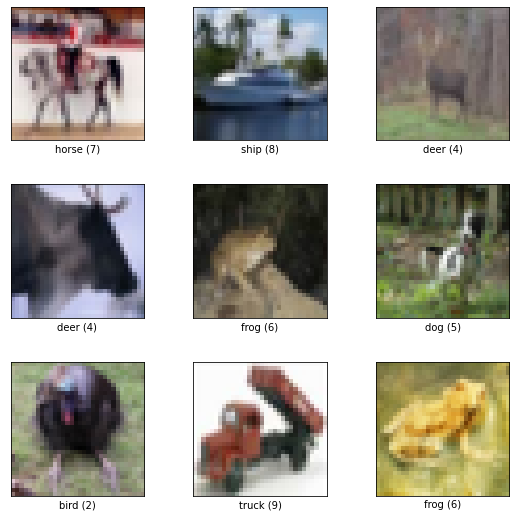

In [26]:
fig = tfds.show_examples(ds_train, ds_info)

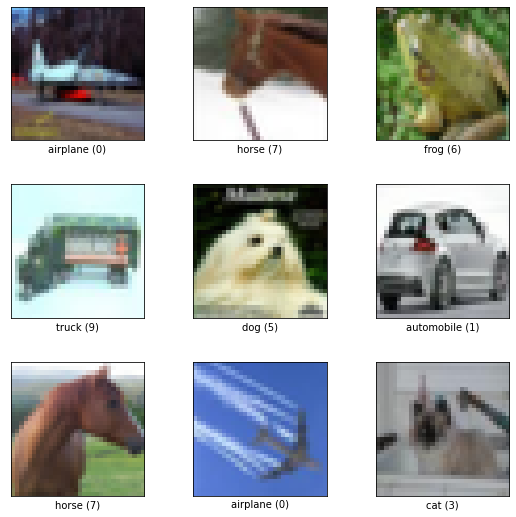

In [27]:
fig = tfds.show_examples(ds_test, ds_info)

## (2) 블록 구성하기    

---------------------------

* 모델을 프로그램으로 구현하는 과정에서 논문의 모델을 그대로 구현하는 것도 중요하지만
* 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요
* 블록 : 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위   
* 레이어(layer) : 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위   


* 프로젝트로 구현할 ResNet을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크가 있는데, 각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 되므로 ResNet의 기본 구조인 블록을 먼저 구현해보도록 하겠습니다.

### 2-1) VGG 기본 블록 만들기

In [39]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [40]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [41]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## (3) VGG Complete Model

### 3-1) VGG-16

In [42]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [43]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 3-2) VGG-19

In [44]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## (4) VGG-16 vs VGG-19

--------------------------------

* 모델의 성능 비교를 위해서 모델을 훈련하고 평가해보도록 하겠습니다!
* GG는 레이어의 차이를 위해서 VGG-16과 VGG-19를 비교해보도록 할께요

우선 CIFAR-10 데이터셋을 불러옵시다.

In [45]:
BATCH_SIZE = 256
EPOCH = 20

In [46]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

VGG-16 모델을 만들고 훈련시켜 줍니다.

In [47]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 89s 339ms/step - loss: 2.2544 - accuracy: 0.1483 - val_loss: 2.1031 - val_accuracy: 0.1939
Epoch 2/20
195/195 [==============================] - 46s 238ms/step - loss: 2.0400 - accuracy: 0.2630 - val_loss: 1.9211 - val_accuracy: 0.3176
Epoch 3/20
195/195 [==============================] - 47s 240ms/step - loss: 1.8893 - accuracy: 0.3146 - val_loss: 1.7656 - val_accuracy: 0.3699
Epoch 4/20
195/195 [==============================] - 47s 239ms/step - loss: 1.7714 - accuracy: 0.3588 - val_loss: 1.7062 - val_accuracy: 0.3873
Epoch 5/20
195/195 [==============================] - 47s 240ms/step - loss: 1.6801 - accuracy: 0.3958 - val_loss: 1.6564 - val_accuracy: 0.4038
Epoch 6/20
195/195 [==============================] - 47s 241ms/step - loss: 1.6265 - accuracy: 0.4140 - val_loss: 1.5728 - val_accuracy: 0.4201
Epoch 7/20
195/195 [==============================] - 47s 240ms/step - loss: 1.5689 - accuracy: 0.4366 - val_loss: 1.5322 - val_ac

VGG-19 모델을 만들고 훈련시켜 줍니다.

In [48]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 60s 281ms/step - loss: 2.2883 - accuracy: 0.1352 - val_loss: 2.1927 - val_accuracy: 0.2099
Epoch 2/20
195/195 [==============================] - 55s 283ms/step - loss: 2.1285 - accuracy: 0.2115 - val_loss: 1.9852 - val_accuracy: 0.2948
Epoch 3/20
195/195 [==============================] - 55s 285ms/step - loss: 1.9672 - accuracy: 0.2868 - val_loss: 1.8801 - val_accuracy: 0.3177
Epoch 4/20
195/195 [==============================] - 56s 286ms/step - loss: 1.8373 - accuracy: 0.3349 - val_loss: 1.7736 - val_accuracy: 0.3625
Epoch 5/20
195/195 [==============================] - 56s 286ms/step - loss: 1.7359 - accuracy: 0.3680 - val_loss: 1.7257 - val_accuracy: 0.3622
Epoch 6/20
195/195 [==============================] - 56s 287ms/step - loss: 1.6614 - accuracy: 0.3976 - val_loss: 1.5652 - val_accuracy: 0.4408
Epoch 7/20
195/195 [==============================] - 56s 287ms/step - loss: 1.5882 - accuracy: 0.4256 - val_loss: 1.5915 - val_ac

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠습니다.       
먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해볼께요!

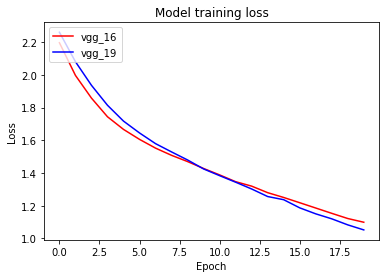

In [49]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

검증 정확도(validation accuracy)를 비교해볼께요

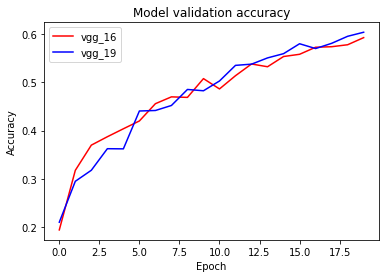

In [50]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()